In [1]:
import pandas as pd
import numpy as np

### Create data

In [105]:
import matplotlib.pyplot as plt
import math
from random import uniform


def torus_data(num = 5000, r1 = 4, r2 = 1, display = True):
    pi = math.pi

    df = []
    for i in range(num):
        point = uniform(0, r1)

        noise_x = uniform(-r2, r2)
        noise_y = uniform(-r2, r2)
        noise_z = uniform(-r2, r2)
        df.append([(math.cos(2*pi*point)*r1) + noise_x, (math.sin(2*pi*point)*r1) + noise_y, noise_z])
    df = pd.DataFrame(df)

    if display:
        fig = plt.figure(figsize=(8, 15))
        ax = fig.add_subplot(projection='3d')

        ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(), c=df[2].tolist())
        ax.set_xlim(-max(abs(r1), abs(r2))-1,max(abs(r1), abs(r2))+1)
        ax.set_ylim(-max(abs(r1), abs(r2))-1,max(abs(r1), abs(r2))+1)
        ax.set_zlim(-max(abs(r1), abs(r2))-1,max(abs(r1), abs(r2))+1)

    return df

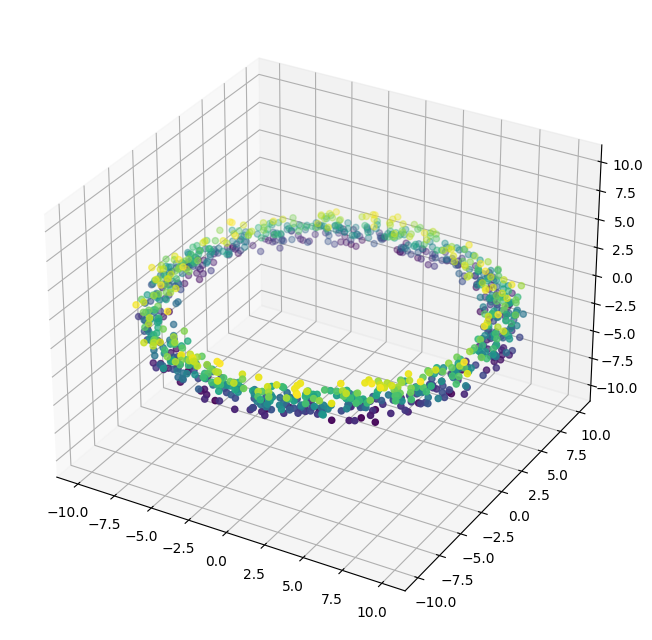

In [106]:
df_torus = torus_data(1000, 10, 1)

### Diffusion maps

Два гиперпараметра: время t и alpha

In [4]:
from tqdm import tqdm
from sklearn.preprocessing import normalize

In [5]:
def gaussian_kernel(x, y, alpha):
    x = np.array(x)
    y = np.array(y)
    return np.exp((-np.abs(x-y).sum()**2)/alpha)

def diffusion_matrix(df, alpha):
    K = np.zeros((df.shape[0], df.shape[0]))

    for i in tqdm(range(df.shape[0])):
        x = df.iloc[i].tolist()
        for j in range(df.shape[0]):
            y = df.iloc[j].tolist()

            K[i, j] = gaussian_kernel(x, y, alpha)

    P = normalize(K, axis= 1 , norm='l1')
    return P

In [14]:
P_torus = diffusion_matrix(df_torus, 0.4) # тут передаем первый гиперпараметр

100%|██████████| 1000/1000 [00:54<00:00, 18.48it/s]


In [15]:
from scipy.sparse.linalg import eigs

def dim_reduction(P, dim, t):

    vals, vecs = eigs(P, dim)
    P_eig = vals ** t * vecs

    return vals, vecs, P_eig

In [113]:
vals, vecs, outp_torus = dim_reduction(P_torus, 2, 7) # тут передаем размерность + время t

### Тоp

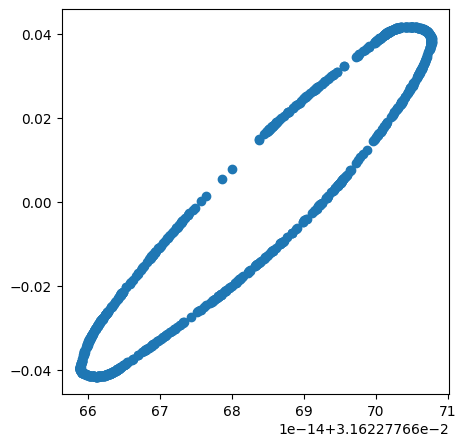

In [29]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(outp_torus[:, 0], outp_torus[:, 1])
plt.show()

In [114]:
vals

array([1.        +0.j, 0.99993256+0.j])

Немного странная картинка, возможно, возникает из-за того, что самое большое собственное значение равняется единице, что не очень хорошо, так как, например, возведение его в степень t нам ничего не меняет (хотя должны проявляться все более близкие связи в исходных данных)

Попробуем взять второй и третий собственные вектора

In [109]:
def dim_reduction1(P, dim, t):

    vals, vecs = eigs(P, dim+1)
    vals = vals[1:]
    vecs = vecs[:,1:]
    P_eig = vals ** t * vecs

    return vals, vecs, P_eig

In [110]:
vals, vecs, outp_torus = dim_reduction1(P_torus, 2, 7) # тут передаем размерность + время t

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


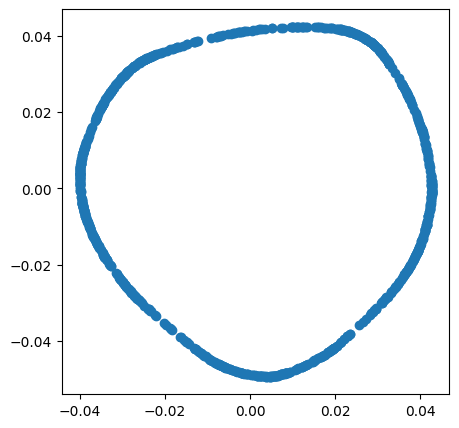

In [111]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(outp_torus[:, 0], outp_torus[:, 1])
plt.show()

Так значительно лучше + масштаб одной оси относительно другой приемлемый. Видимо, в том случае мы как бы смотрим на тор не сверху, как нам бы хотелось, а сбоку под небольшим углом

Посмотрим на результаты tsne

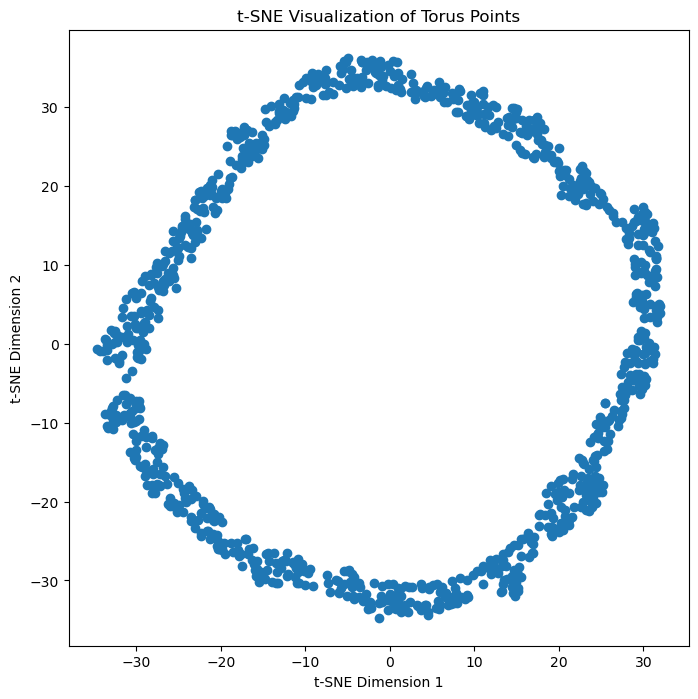

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(df_torus)

df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])

plt.figure(figsize=(8, 8))
plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'])
plt.title('t-SNE Visualization of Torus Points')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Немного другая реализация. Тут гиперпараметр alpha. Побыстрее, так как матрицу диффузии ищем с помощью встроенного метода поиска попарных расстояний

In [30]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

In [115]:
def find_diffusion_matrix(df, alpha=4):
    X = np.array(df)

    dists = euclidean_distances(X, X)
    K = np.exp(-dists**2 / alpha)

    r = np.sum(K, axis=0)
    Di = np.diag(1/r)
    P = np.matmul(Di, K)

    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))

    return P_prime, P, Di, K, D_left

In [116]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(df_torus, 2) # гиперпараметр альфа

In [117]:
from scipy.linalg import eigh

In [119]:
def find_diffusion_map(P_prime, D_left, n_eign=2):

    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    diffusion_coordinates = np.matmul(D_left, eigenVectors)

    return diffusion_coordinates[:,:n_eign], eigenVectors, eigenValues

In [56]:
outp,_,_ = find_diffusion_map(P_prime, D_left, 2) # размерность нового пространства передаем

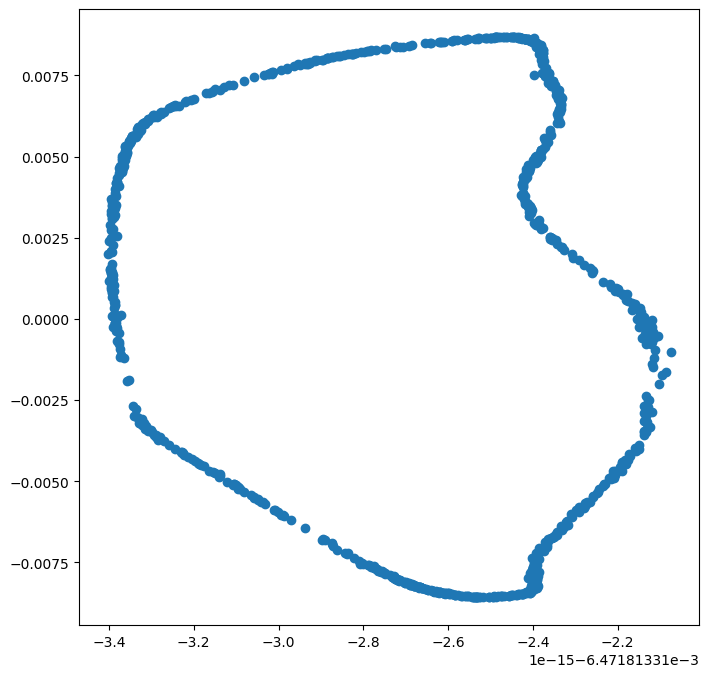

In [57]:
fig = plt.figure(figsize=(8, 8))

plt.scatter(outp[:, 0], outp[:, 1])
plt.show()

Основная топология (окружность) видна при двумерном вложении

Но давайте опять же посмотрим для второго и третьего собственых векторов:

In [120]:
def find_diffusion_map1(P_prime, D_left, n_eign=2):

    eigenValues, eigenVectors = eigh(P_prime)
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    diffusion_coordinates = np.matmul(D_left, eigenVectors)

    return diffusion_coordinates[:,1:n_eign+1], eigenVectors, eigenValues

In [134]:
outp,_,_ = find_diffusion_map1(P_prime, D_left, 2) # размерность нового пространства передаем

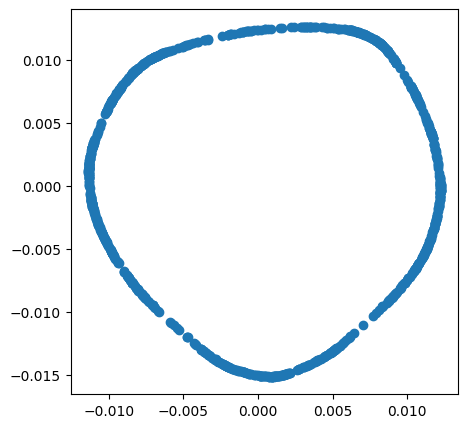

In [135]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(outp[:, 0], outp[:, 1])
plt.show()

Поработаем с кластеризацией

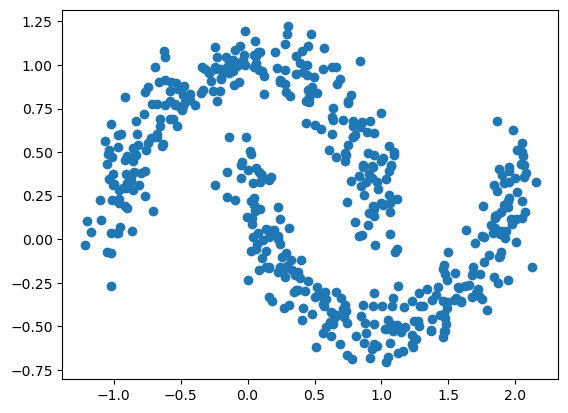

In [ ]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [ ]:
from sklearn.cluster import KMeans

def get_labels(Y, clusters):

    kmeans = KMeans(clusters)
    kmeans = kmeans.fit(Y)
    labels = np.array(kmeans.predict(Y)).reshape(500,1)

    return labels

K-means до применения диффузионных карт:

c:\Users\FUAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


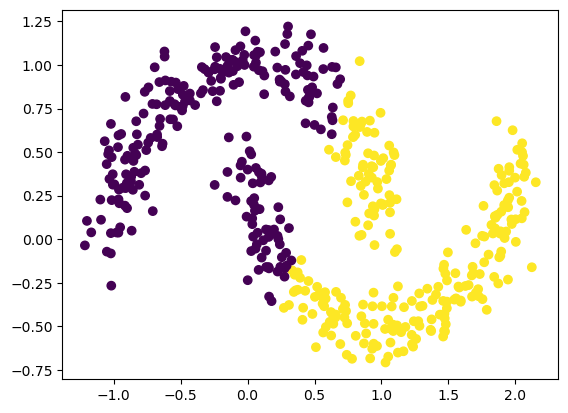

In [ ]:
labels = get_labels(X, 2)
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

Теперь вложим наши данные в пространство большей размерности (3) и применим K-means!

In [ ]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(X, 0.01)
outp, eigenVectors, eigenValues = find_diffusion_map(P_prime, D_left, 3)

In [ ]:
labels = get_labels(outp, 2)

c:\Users\FUAD\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


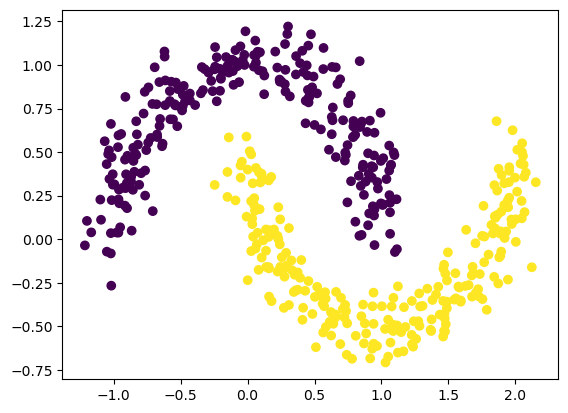

In [ ]:
plt.scatter(X[:,0], X[:,1], c=labels)
plt.show()

Теперь кластеризация правильная

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
X, y = mnist.data.astype(np.float32), mnist.target
ix_perm = np.random.permutation(X.shape[0])
X, y = X.iloc[ix_perm, :], y.iloc[ix_perm]

c:\Users\FUAD\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
X_subset, y_subset = X[:100], y[:100]
X_subset /=255

df_mnist = diffusion_matrix(X_subset, 0.5)
vals, vecs, outp_mnist = dim_reduction(df_mnist, 2, 1) # тут передаем размерность + время t
y_numeric = y_subset.astype(int)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:08<00:00, 11.48it/s]


c:\Users\FUAD\anaconda3\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\FUAD\anaconda3\lib\site-packages\matplotlib\collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


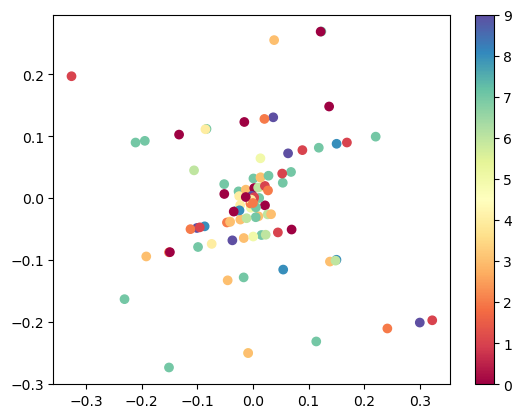

In [ ]:
plt.scatter(outp_mnist[:, 0], outp_mnist[:, 1], c=y_numeric, cmap=plt.cm.Spectral)
plt.colorbar()
plt.show()

c:\Users\FUAD\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


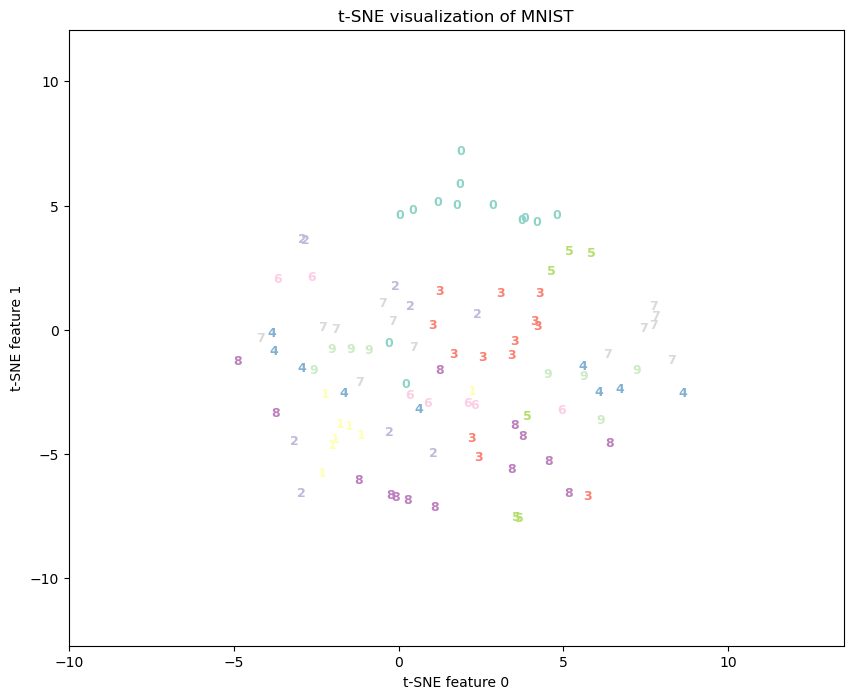

In [ ]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data.astype(np.float32), mnist.target

ix_perm = np.random.permutation(X.shape[0])
X, y = X[ix_perm, :], y[ix_perm]

X_subset, y_subset = X[:100], y[:100]

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

plt.figure(figsize=(10, 8))
for i in range(X_tsne.shape[0]):
    plt.text(X_tsne[i, 0], X_tsne[i, 1], str(int(y_subset[i])), color=plt.cm.Set3(int(y_subset[i])/10),
             fontdict={'weight': 'bold', 'size': 9})
plt.xlim(X_tsne[:, 0].min()-5, X_tsne[:, 0].max()+5)
plt.ylim(X_tsne[:, 1].min()-5, X_tsne[:, 1].max()+5)
plt.xlabel('t-SNE feature 0')
plt.ylabel('t-SNE feature 1')
plt.title('t-SNE visualization of MNIST')
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from pydiffmap import diffusion_map as dm

In [ ]:
# set parameters
length_phi = 15   #length of swiss roll in angular direction
length_Z = 15     #length of swiss roll in z direction
sigma = 0.1       #noise strength
m = 10000         #number of samples

# create dataset
phi = length_phi*np.random.rand(m)
xi = np.random.rand(m)
Z = length_Z*np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)

swiss_roll = np.array([X, Y, Z]).transpose()

# check that we have the right shape
print(swiss_roll.shape)

(10000, 3)


In [ ]:
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
dmap = mydmap.fit_transform(swiss_roll)

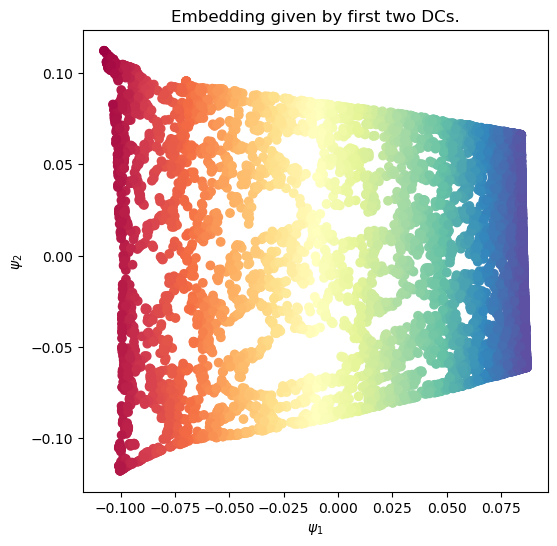

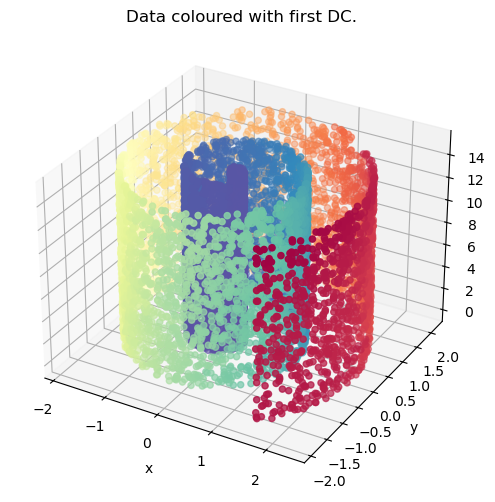

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

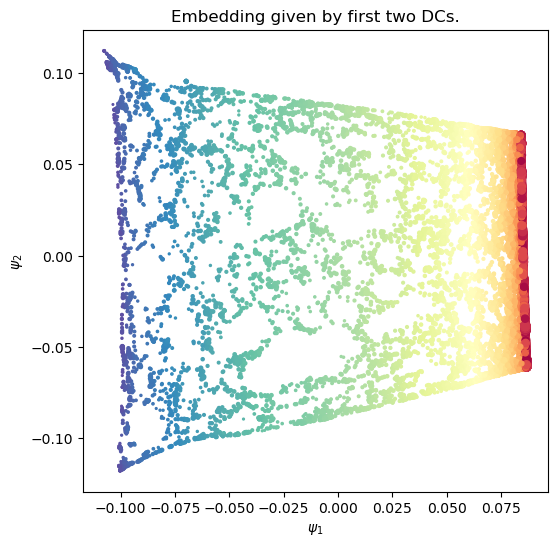

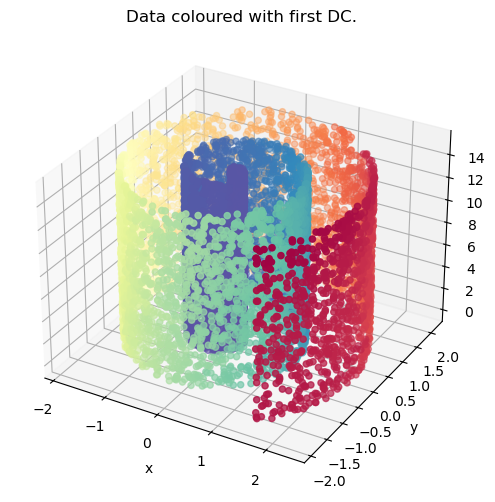

In [ ]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': phi, 's': mydmap.q, 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})
plt.show()

Correlation between \phi and \psi_1
[[ 1.         -0.92446863]
 [-0.92446863  1.        ]]
Correlation between Z and \psi_2
[[1.         0.97326599]
 [0.97326599 1.        ]]


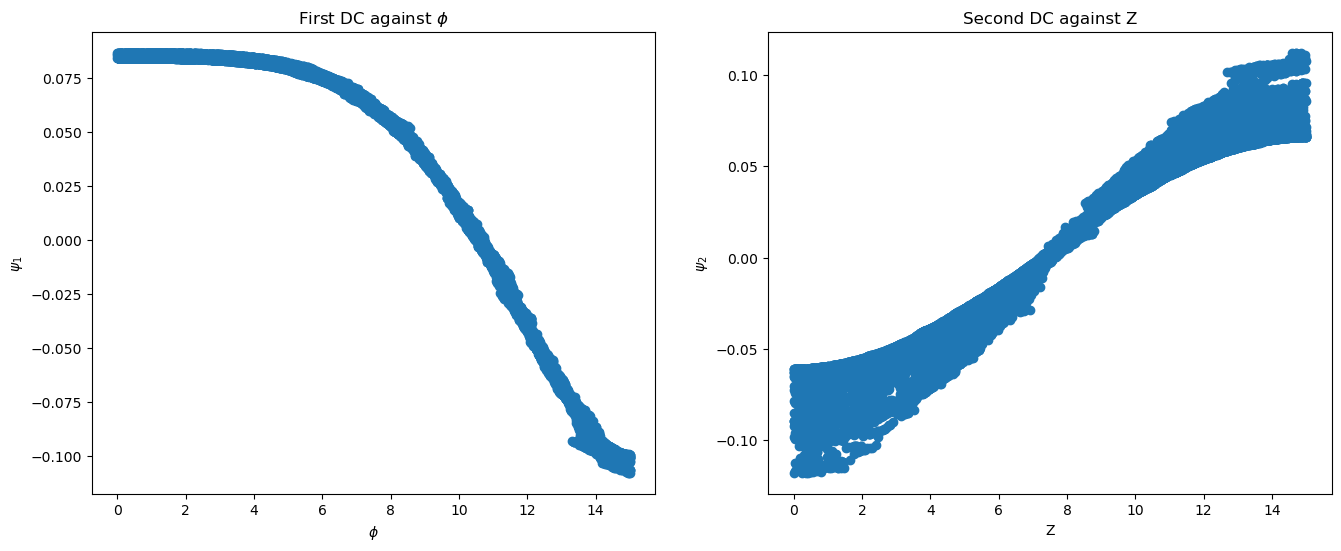

In [ ]:
print('Correlation between \phi and \psi_1')
print(np.corrcoef(dmap[:,0], phi))

plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(phi, dmap[:,0])
ax.set_title('First DC against $\phi$')
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\psi_1$')
ax.axis('tight')

print('Correlation between Z and \psi_2')
print(np.corrcoef(dmap[:,1], Z))

ax2 = plt.subplot(122)
ax2.scatter(Z, dmap[:,1])
ax2.set_title('Second DC against Z')
ax2.set_xlabel('Z')
ax2.set_ylabel(r'$\psi_2$')

plt.show()

In [ ]:
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1000, neighbor_params=neighbor_params)
dmap = mydmap.fit_transform(X_subset)

In [ ]:
import plotly.express as px

y_numeric = y_subset.astype(int)

fig = px.scatter(x=dmap[:, 0], y=dmap[:, 1], color=y_numeric,
                 labels={'color': 'Digit Label'})

fig.update_layout(
    title='D-map visualization of MNIST with Plotly',
    xaxis=dict(title='DC 1'),
    yaxis=dict(title='DC 2')
)

fig.show()


### Outlier detection

In [180]:
from copy import deepcopy
df = deepcopy(df_torus)

In [181]:
df[1] = df[1].apply(lambda x: x + float(np.random.rand(1)) * 10)
df[2] = df[2].apply(lambda x: x + float(np.random.rand(1)) * 5)
df[0] = df[0].apply(lambda x: x + float(np.random.rand(1)) * 10)
df

,0,1,2
0,16.814371,0.727538,0.354207
1,6.645168,17.528218,2.557041
2,8.976377,-6.422998,0.966837
3,-4.459172,-7.888565,1.984782
4,19.791898,4.721903,0.485742
...,...,...,...
995,12.693255,18.097656,1.876828
996,11.088186,5.073130,1.532833
997,2.243101,14.684552,4.152703
998,-6.148630,-4.799429,1.840694


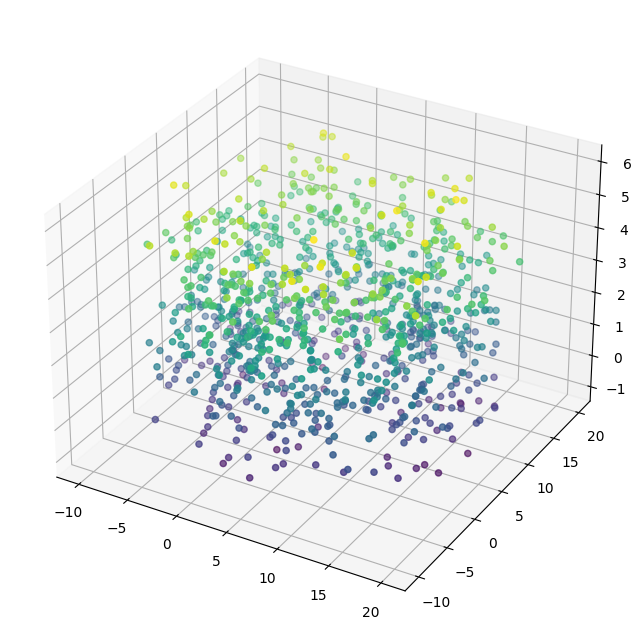

In [182]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(), c=df[2].tolist())

Тут мы сильно зашумили тор и у нас будет много аутлайеров при стандартных методах детекции аномалий. Диффузионные карты же ищут близкие связи между точками, поэтому отображение опять же в трехмерное пространство даст нам нечто с более плотной структурой. Убедиться в этом можно с помощью визуализации ниже:

In [183]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(df, 3)
outp, eigenVectors, eigenValues = find_diffusion_map1(P_prime, D_left, 3)

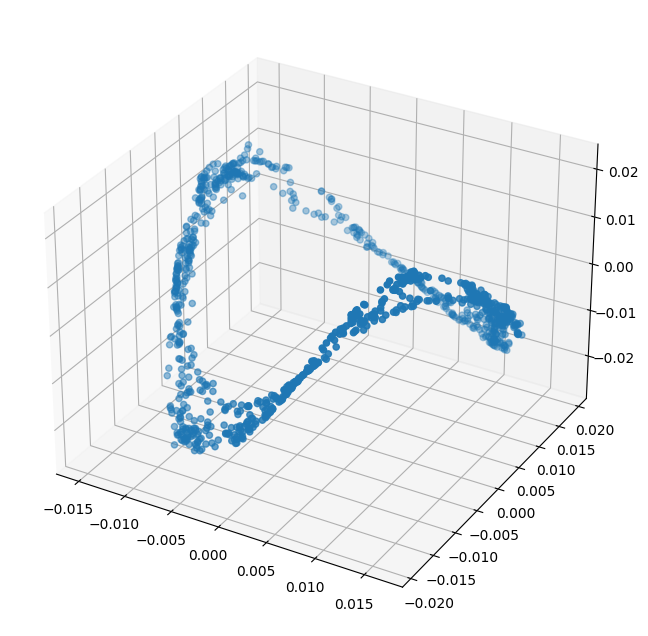

In [184]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(outp[:,0].tolist(), outp[:,1].tolist(), outp[:,2].tolist())
plt.show()

Кстати, вложение в двумерное пространство уже не будет строгой окружностью, так как данные сильно зашумлены:

In [185]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(df, 3)
outp, eigenVectors, eigenValues = find_diffusion_map1(P_prime, D_left, 2)

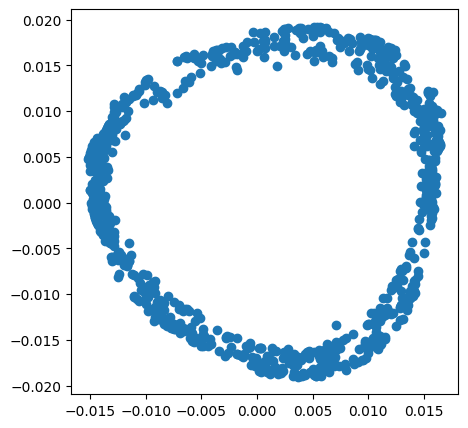

In [186]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(outp[:, 0], outp[:, 1])
plt.show()

Детекцию аномалий можно привести, например, с помощью алгоритма DBSCAN. Темно фиолетовые точки на картинке ниже означают, что точка выбивается из общего паттерна данных

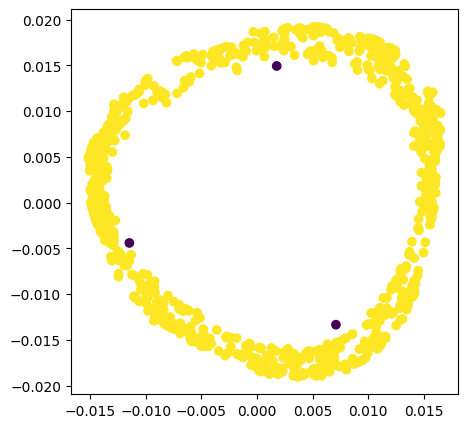

In [202]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.00118, min_samples=2).fit(outp)

fig = plt.figure(figsize=(5, 5))

plt.scatter(outp[:, 0], outp[:, 1], c = clustering.labels_)
plt.show()

Визуально мы обноружили все явные аномалии в нашем двумерном случае, но их двольно мало, то есть для исходных трехмерных данных мы нашли только самые очевидные аутлайеры

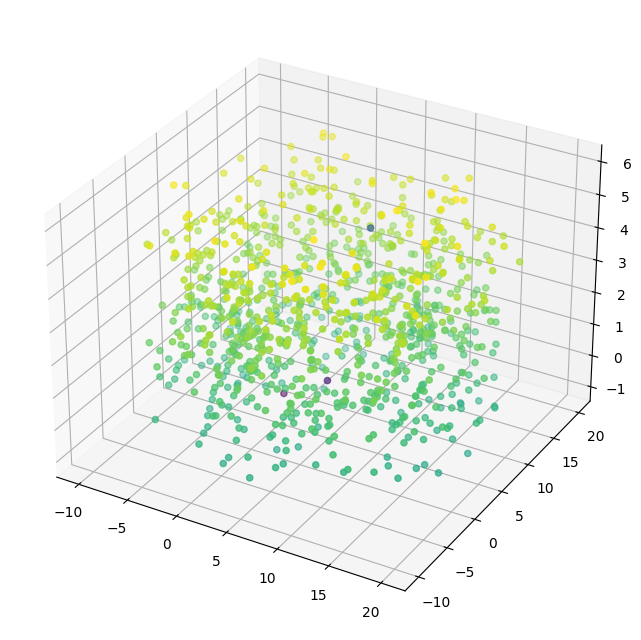

In [215]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(), c=(clustering.labels_*100)+np.array(df[2].tolist())*10)

Но смысла переходить в меньшую размерность, чтобы найти аутлайеры, не очень много, так как мы теряем информацию. Лучше остаться в той же размерности (или в большей), и там провести наш алгоритм

In [216]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(df, 3)
outp, eigenVectors, eigenValues = find_diffusion_map1(P_prime, D_left, 3)

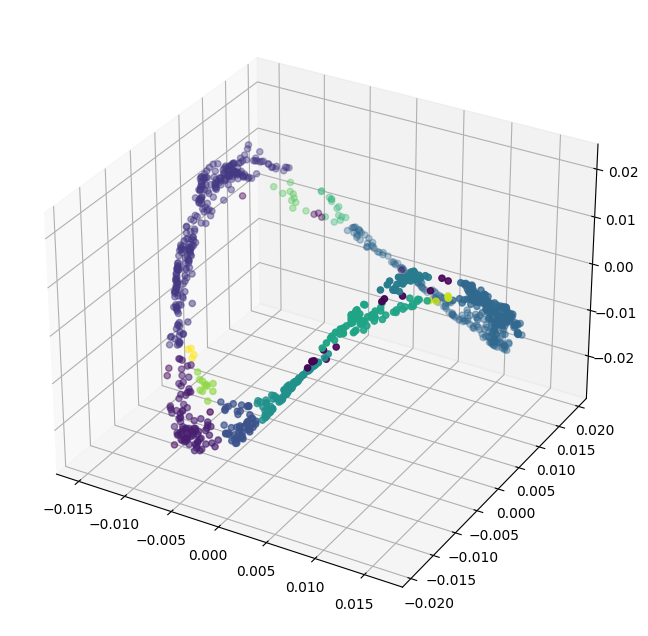

In [230]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.0017, min_samples=5).fit(outp)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(outp[:,0].tolist(), outp[:,1].tolist(), outp[:,2].tolist(),c = clustering.labels_)
plt.show()

Нам тут не очень важно то, что основных кластеров довольно много, а не один. Нам интересны аномалии и малочисленные кластеры - тоже один из признаков аномальности

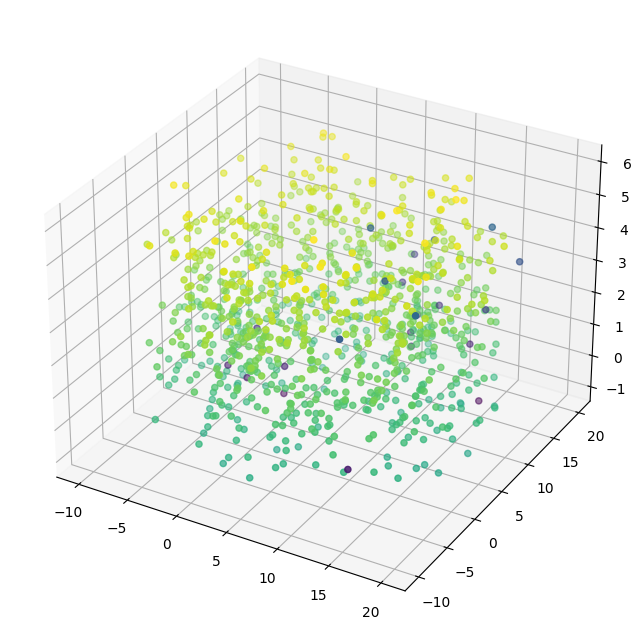

In [232]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(projection='3d')

anomalies = deepcopy(clustering.labels_)
anomalies[anomalies != -1] = 0

ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(), c=(anomalies*100)+np.array(df[2].tolist())*10)

Посмотрим DBSCAN на исходных данных: заметим, что для большого eps у нас один аутлайер, который выше был тоже сдетектирован нашим специальным методом

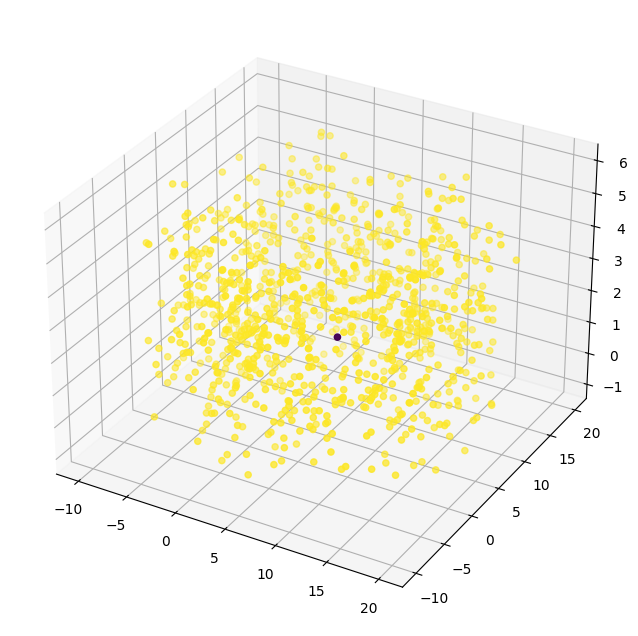

In [236]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=3, min_samples=5).fit(df)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(),c = clustering.labels_)
plt.show()

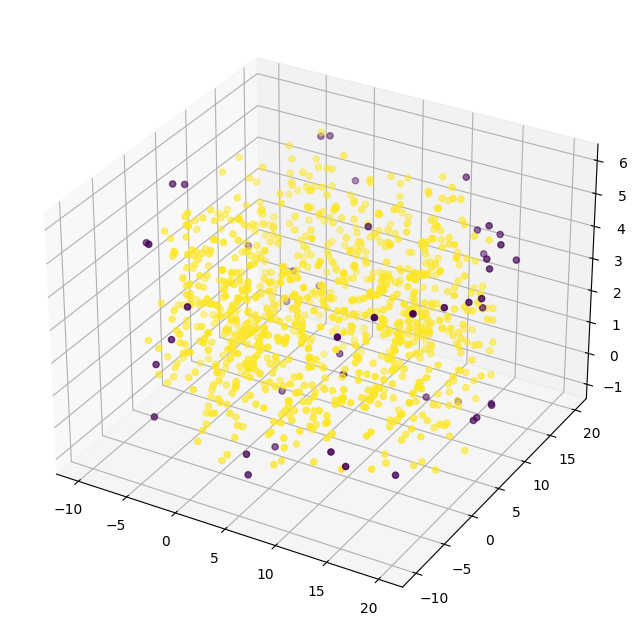

In [237]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=2, min_samples=5).fit(df)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(), c = clustering.labels_)
plt.show()

Конечно, в общем случае прямой метод и через вложение с помощью диффузионных карт будут отличаться, так как прямой метод просто смотрит на расстояния, а наш - на общую топологическую структуру данных

Можно еще попробовать с вложение в большее пространство:

In [238]:
P_prime, P, Di, K, D_left = find_diffusion_matrix(df, 3)
outp, eigenVectors, eigenValues = find_diffusion_map1(P_prime, D_left, 5)

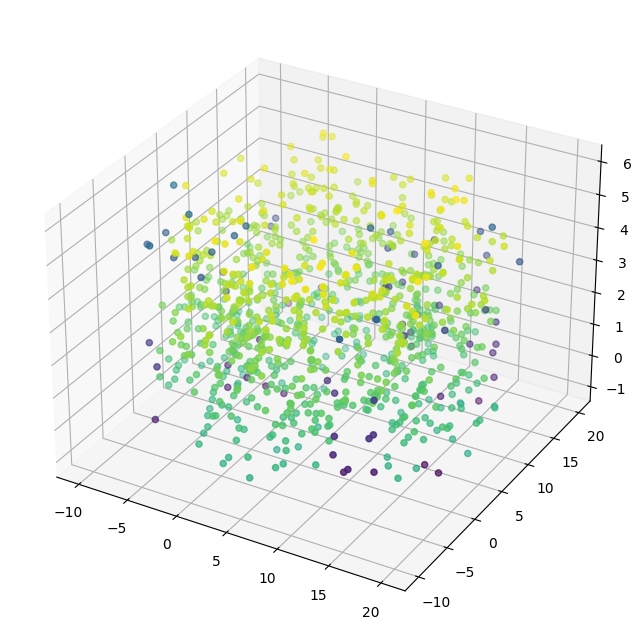

In [243]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot(projection='3d')

clustering = DBSCAN(eps=0.003, min_samples=5).fit(outp)
anomalies = deepcopy(clustering.labels_)
anomalies[anomalies != -1] = 0

ax.scatter3D(df[0].tolist(), df[1].tolist(), df[2].tolist(), c=(anomalies*100)+np.array(df[2].tolist())*10)

Вроде хорошо вышло довольно